<a href="https://www.kaggle.com/code/crustacean/pytorch-forecasting-temporal-fusion-transformer?scriptVersionId=216295267" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

google research blog post about the architecture:

https://research.google/blog/interpretable-deep-learning-for-time-series-forecasting/

Link to paper "Temporal Fusion Transformers for interpretable multi-horizon time series forecasting": 

https://www.sciencedirect.com/science/article/pii/S0169207021000637

In [1]:
! pip install pytorch-forecasting

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.4/40.4 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.9/181.9 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 20.4 MB/s eta 0:00:00


In [2]:
import numpy as np 
import pandas as pd
import datetime as dt
from catboost import CatBoostRegressor
from sklearn.base import clone
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import matplotlib.dates as mdates
import warnings
warnings.filterwarnings('ignore')

import copy
from pathlib import Path
import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from lightning.pytorch.loggers import TensorBoardLogger
import torch
from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import MAE, SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

In [3]:
train = pd.read_csv('/kaggle/input/rohlik-sales-forecasting-challenge-v2/sales_train.csv')
test = pd.read_csv('/kaggle/input/rohlik-sales-forecasting-challenge-v2/sales_test.csv')
solution = pd.read_csv('/kaggle/input/rohlik-sales-forecasting-challenge-v2/solution.csv')
inv = pd.read_csv("/kaggle/input/rohlik-sales-forecasting-challenge-v2/inventory.csv")
cle = pd.read_csv("/kaggle/input/rohlik-sales-forecasting-challenge-v2/calendar.csv")
test_weights = pd.read_csv('/kaggle/input/rohlik-sales-forecasting-challenge-v2/test_weights.csv')
train = train.merge(inv,on=['warehouse','unique_id'],how='left')
train['unique_id_and_name'] = train['unique_id'].astype(str) + '_' + train['name']
train['date'] = pd.to_datetime(train['date'])
test['date'] = pd.to_datetime(test['date'])

In [4]:
nan_count = train.sales.isna().sum()
print(f"Number of NaN entries in 'sales': {nan_count}")
train = train.dropna(subset=['sales'])
nan_count_after = train.sales.isna().sum()
print(f"Number of NaN entries in 'sales' after dropping: {nan_count_after}")

Number of NaN entries in 'sales': 52
Number of NaN entries in 'sales' after dropping: 0


In [5]:
# add time index
min_time_idx = train['date'].min()
train['time_idx'] = (train['date'] - min_time_idx).dt.days
train['unique_id'] = train['unique_id'].astype(str).astype('category')
test['time_idx'] = (test['date'] - min_time_idx).dt.days
test['unique_id'] = test['unique_id'].astype(str).astype('category')
test['sales'] = 0.0
test = pd.concat([train, test], ignore_index=True)

In [6]:
test.time_idx.min()

0

In [7]:
max_prediction_length = 28
max_encoder_length = 28
training_cutoff = train["time_idx"].max() # - max_prediction_length

training = TimeSeriesDataSet(
    train, #[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="sales",
    group_ids=["unique_id"],
    min_encoder_length=1, # max_encoder_length // 2,
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    static_categoricals=[
        "unique_id",
        'warehouse',
    ],
    static_reals=[],
    time_varying_known_categoricals=[],
    time_varying_known_reals=[
        "time_idx",
        'total_orders',
        'sell_price_main',
        'type_0_discount',
        'type_1_discount',
        'type_2_discount',
        'type_3_discount',
        'type_4_discount',
        'type_5_discount',
        'type_6_discount',
    ],
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=[
        'sales',
    ],
    target_normalizer=GroupNormalizer(
        groups=["unique_id"], transformation="softplus"
    ),  # use softplus and normalize by group
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
    allow_missing_timesteps=True,
)

validation = TimeSeriesDataSet.from_dataset(training, train, predict=True, stop_randomization=True)

batch_size = 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=0) # batch_size=batch_size * 10

In [8]:
trainer = pl.Trainer(
    max_epochs= 200, 
    accelerator="gpu",
    enable_model_summary=True,
    gradient_clip_val=0.1,
    limit_train_batches=50,
)

tft = TemporalFusionTransformer.from_dataset(
    training,
    loss=MAE(),
    log_interval=10,  
    optimizer="adamw",
)
print(f"Number of parameters in network: {tft.size() / 1e3:.1f}k")

INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs


Number of parameters in network: 117.5k


In [9]:
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | loss                               | MAE                             | 0      | train
1  | logging_metrics                    | ModuleList                      | 0      | train
2  | input_embeddings                   | MultiEmbedding                  | 86.3 K | train
3  | prescalers                         | ModuleDict                      | 240    | train
4  | static_variable_selection          | VariableSelectionNetwork        | 2.0 K  | train
5  | encoder_variable_selection         | VariableSelectionNetwork        | 8.2 K  | train
6  | decoder_variable_selection         | VariableSelectionNetwork        | 7.4 K  | train
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K  | train
8  | static_context_initial_h

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=200` reached.


In [10]:
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

In [11]:
raw_predictions = best_tft.predict(test, 
                                   mode="raw", 
                                   return_x=True, 
                                   return_index=True,
                                  )

INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


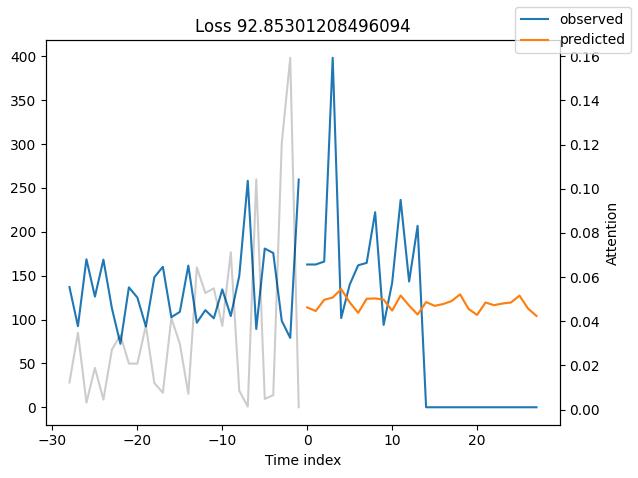

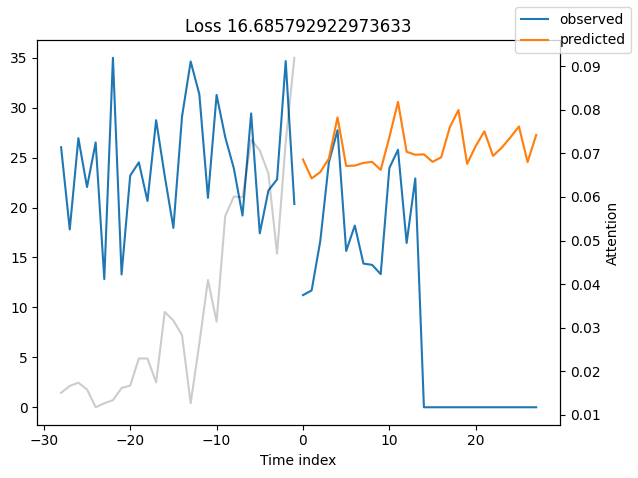

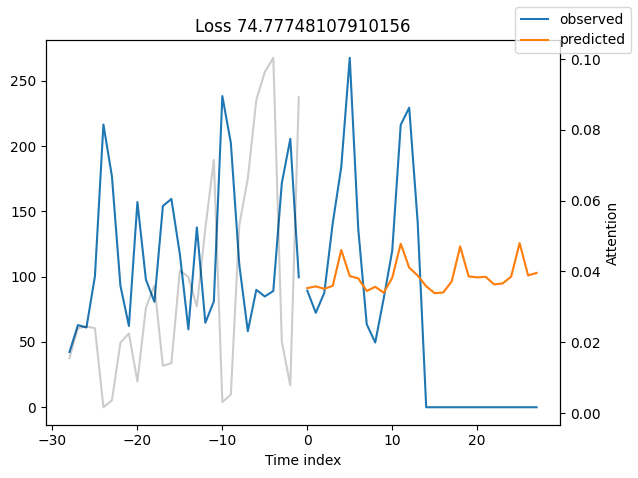

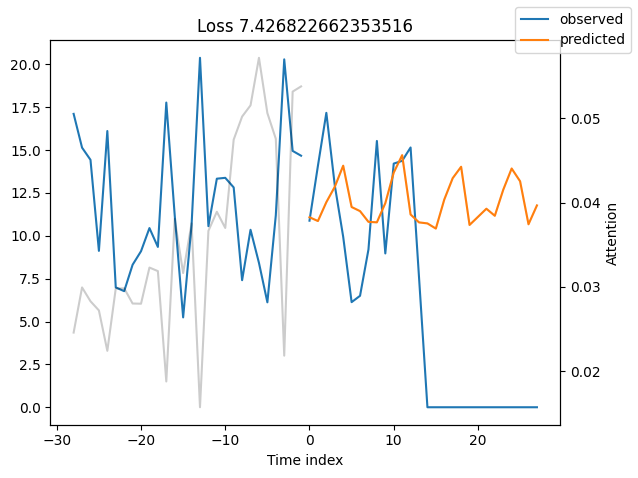

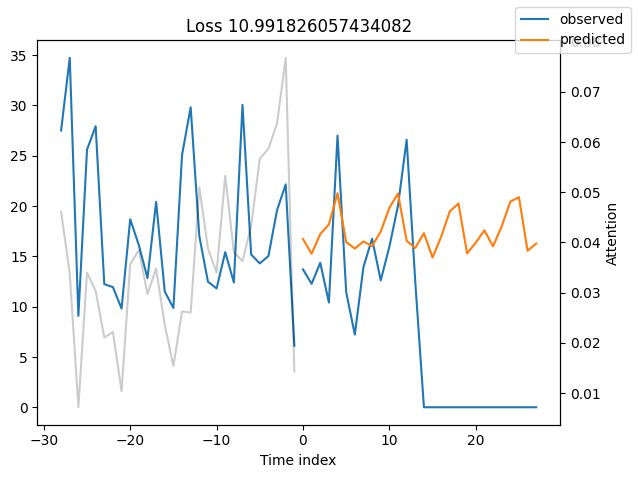

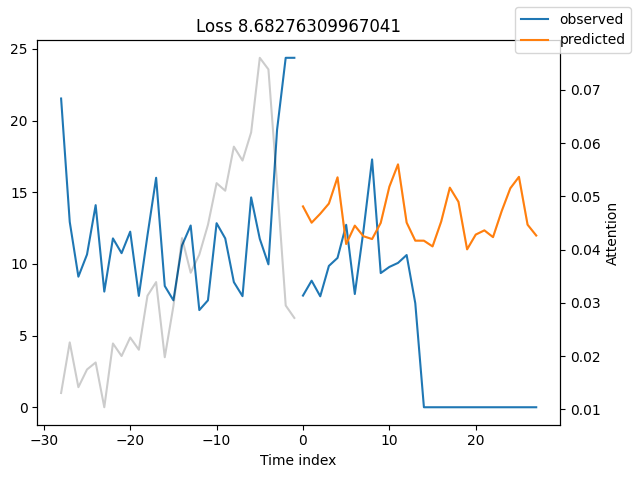

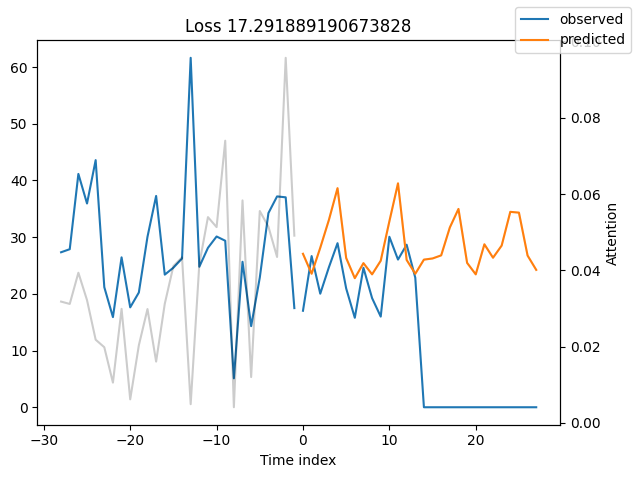

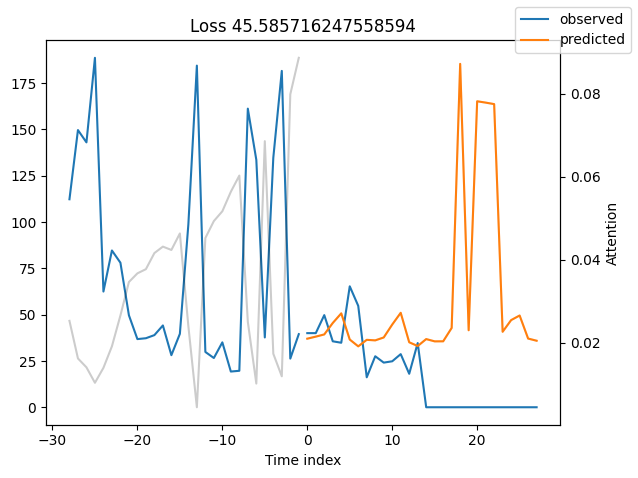

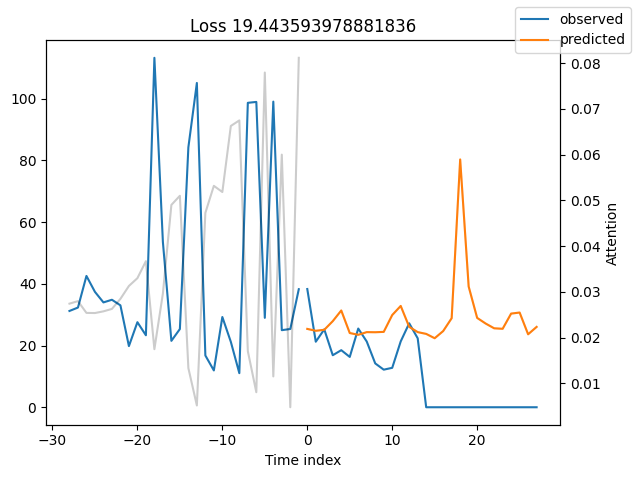

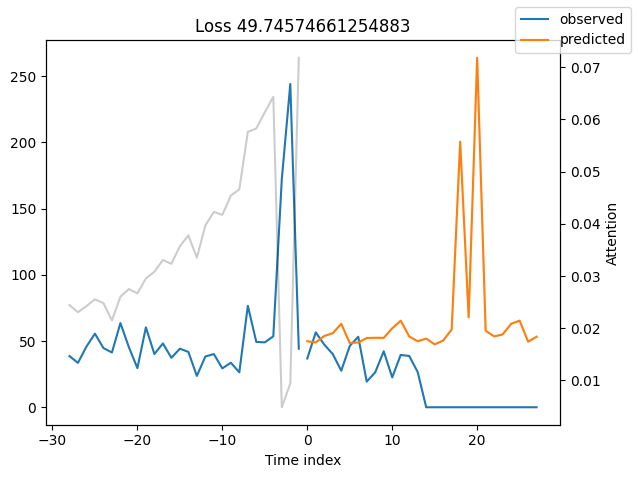

In [12]:
for idx in range(10):
    best_tft.plot_prediction(raw_predictions.x, raw_predictions.output, idx=idx, add_loss_to_title=True)

In [13]:
pred_index = raw_predictions.index
preds = raw_predictions.output.prediction.cpu()

In [14]:
pred_index

,time_idx,unique_id
0,1388,1
1,1388,10
2,1388,100
3,1388,1001
4,1388,1002
...,...,...
4941,1388,995
4942,1388,996
4943,1388,997
4944,1388,998


In [15]:
preds.shape

torch.Size([4946, 28, 1])

In [16]:
pred_index.time_idx.count()

4946

# create submission file

In [17]:
solution = pd.read_csv('/kaggle/input/rohlik-sales-forecasting-challenge-v2/solution.csv')

In [18]:
solution = solution[['id']]

In [19]:
solution[['unique_id', 'date']] = solution['id'].str.split('_', expand=True)

In [20]:
train['date'].min()

Timestamp('2020-08-01 00:00:00')

In [21]:
# Add time_idx to solution
solution['date'] = pd.to_datetime(solution['date'])
start_date = train['date'].min()
solution['time_idx'] = (solution['date'] - start_date).dt.days

In [22]:
solution

,id,unique_id,date,time_idx
0,1226_2024-06-03,1226,2024-06-03,1402
1,1226_2024-06-11,1226,2024-06-11,1410
2,1226_2024-06-13,1226,2024-06-13,1412
3,1226_2024-06-15,1226,2024-06-15,1414
4,1226_2024-06-09,1226,2024-06-09,1408
...,...,...,...,...
47016,4572_2024-06-03,4572,2024-06-03,1402
47017,3735_2024-06-04,3735,2024-06-04,1403
47018,3735_2024-06-03,3735,2024-06-03,1402
47019,2129_2024-06-03,2129,2024-06-03,1402


In [23]:
# populate solution df with sales_hat
preds = preds.squeeze(-1).numpy()
horizon = preds.shape[1]
pred_index["forecast_idx"] = range(len(pred_index)) 
expanded_forecasts = []

for idx, row in pred_index.iterrows():
    start_time_idx = row["time_idx"]
    unique_id = row["unique_id"]
    forecast_values = preds[idx]
    time_indices = np.arange(start_time_idx, start_time_idx + horizon)
    
    expanded_forecasts.append(pd.DataFrame({
        "time_idx": time_indices,
        "unique_id": unique_id,
        "sales_hat": forecast_values
    }))

expanded_forecasts_df = pd.concat(expanded_forecasts, ignore_index=True)

solution = solution.merge(expanded_forecasts_df, on=["unique_id", "time_idx"], how="left")

In [24]:
solution

,id,unique_id,date,time_idx,sales_hat
0,1226_2024-06-03,1226,2024-06-03,1402,20.591450
1,1226_2024-06-11,1226,2024-06-11,1410,92.017693
2,1226_2024-06-13,1226,2024-06-13,1412,107.684608
3,1226_2024-06-15,1226,2024-06-15,1414,83.831085
4,1226_2024-06-09,1226,2024-06-09,1408,18.131325
...,...,...,...,...,...
47016,4572_2024-06-03,4572,2024-06-03,1402,57.415016
47017,3735_2024-06-04,3735,2024-06-04,1403,165.010162
47018,3735_2024-06-03,3735,2024-06-03,1402,174.151367
47019,2129_2024-06-03,2129,2024-06-03,1402,578.934570


In [25]:
solution.isna().sum()

id              0
unique_id       0
date            0
time_idx        0
sales_hat    1335
dtype: int64

In [26]:
solution[solution['sales_hat'].isna()]

,id,unique_id,date,time_idx,sales_hat
693,3715_2024-06-12,3715,2024-06-12,1411,NaN
694,3715_2024-06-13,3715,2024-06-13,1412,NaN
695,3715_2024-06-11,3715,2024-06-11,1410,NaN
696,3715_2024-06-16,3715,2024-06-16,1415,NaN
697,3715_2024-06-14,3715,2024-06-14,1413,NaN
...,...,...,...,...,...
46967,1718_2024-06-12,1718,2024-06-12,1411,NaN
46968,1718_2024-06-16,1718,2024-06-16,1415,NaN
46969,1718_2024-06-14,1718,2024-06-14,1413,NaN
46970,1718_2024-06-15,1718,2024-06-15,1414,NaN


# fill missing forecasts with the ones from our catboost baseline

In [27]:
cb_preds = pd.read_csv('/kaggle/input/simple-catboost-baseline/submission.csv')

In [28]:
cb_preds

,id,sales_hat
0,1226_2024-06-03,17.365788
1,1226_2024-06-11,96.603796
2,1226_2024-06-13,115.918434
3,1226_2024-06-15,92.427513
4,1226_2024-06-09,16.427541
...,...,...
47016,4572_2024-06-03,77.140861
47017,3735_2024-06-04,82.772514
47018,3735_2024-06-03,92.997300
47019,2129_2024-06-03,418.324293


In [29]:
solution = solution.merge(cb_preds, on="id", how="left")

In [30]:
solution[solution['sales_hat_x'].isna()]

,id,unique_id,date,time_idx,sales_hat_x,sales_hat_y
693,3715_2024-06-12,3715,2024-06-12,1411,NaN,41.895640
694,3715_2024-06-13,3715,2024-06-13,1412,NaN,45.551086
695,3715_2024-06-11,3715,2024-06-11,1410,NaN,42.393833
696,3715_2024-06-16,3715,2024-06-16,1415,NaN,43.135295
697,3715_2024-06-14,3715,2024-06-14,1413,NaN,50.089179
...,...,...,...,...,...,...
46967,1718_2024-06-12,1718,2024-06-12,1411,NaN,273.399276
46968,1718_2024-06-16,1718,2024-06-16,1415,NaN,273.019541
46969,1718_2024-06-14,1718,2024-06-14,1413,NaN,292.263320
46970,1718_2024-06-15,1718,2024-06-15,1414,NaN,274.495801


In [31]:
solution["sales_hat"] = solution["sales_hat_x"].fillna(solution["sales_hat_y"])

In [32]:
solution

,id,unique_id,date,time_idx,sales_hat_x,sales_hat_y,sales_hat
0,1226_2024-06-03,1226,2024-06-03,1402,20.591450,17.365788,20.591450
1,1226_2024-06-11,1226,2024-06-11,1410,92.017693,96.603796,92.017693
2,1226_2024-06-13,1226,2024-06-13,1412,107.684608,115.918434,107.684608
3,1226_2024-06-15,1226,2024-06-15,1414,83.831085,92.427513,83.831085
4,1226_2024-06-09,1226,2024-06-09,1408,18.131325,16.427541,18.131325
...,...,...,...,...,...,...,...
47016,4572_2024-06-03,4572,2024-06-03,1402,57.415016,77.140861,57.415016
47017,3735_2024-06-04,3735,2024-06-04,1403,165.010162,82.772514,165.010162
47018,3735_2024-06-03,3735,2024-06-03,1402,174.151367,92.997300,174.151367
47019,2129_2024-06-03,2129,2024-06-03,1402,578.934570,418.324293,578.934570


In [33]:
solution = solution[['id','sales_hat']]

# submission

In [34]:
solution.to_csv('submission.csv',index=False)